In [1]:
from __future__ import division
import random

import pandas as pd
import numpy as np

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#!pip install sklearn
from collections import Counter
import os

home_dir = os.getcwd()


/home/ciaskious/anaconda-here/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# Data preparation

In [2]:
def normalize_data(x):
    return (x - x.min(0)) / x.ptp(0)

In [3]:
def preprocess_data(data):
    data = data.replace("na", 0)
    data = data.replace("neg", 0)
    data = data.replace("pos", 1)

    return data

In [4]:
def oversampling(data, target):

    smote = SMOTE(ratio='minority')
    X_sm, y_sm = smote.fit_sample(data, target)

    print(sorted(Counter(y_sm).items()))

    return X_sm, y_sm

In [5]:
def undersampling(data, target):

    tl = TomekLinks(return_indices=True, ratio='majority')
    X_tl, y_tl, id_tl = tl.fit_sample(data, target)
    print(sorted(Counter(y_tl).items()))

    print('Removed indexes:', id_tl)

    return X_tl, y_tl,

In [6]:
def balance_dataset(data, target):
    smt = SMOTETomek(ratio='auto')
    X_smt, y_smt = smt.fit_sample(data, target)

    print(sorted(Counter(y_smt).items()))
    return X_smt, y_smt

In [16]:
def prepare():
    
    # our training and test datasets
    X_train = pd.read_csv(home_dir + '/scania/training_set_new.csv')
    X_test = pd.read_csv(home_dir + '/scania/test_set_new.csv') 

    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    sns.countplot('class', data = X_train)
    plt.title('Anomaly (1) vs. Normal (0)')
        
    y_train = X_train.iloc[:, 0]  # First column in labels
    y_test = X_test.iloc[:, 0]  # First column in labels

    X_train = X_train.drop(X_train.columns[0], axis=1)  # delete first column of xtrain
    X_test = X_test.drop(X_test.columns[0], axis=1)  # delete first column of xtest    
    X_train_balanced, y_train_balanced = undersampling(X_train, y_train)

        
    return X_train_balanced, X_test, y_train_balanced, y_test

NameError: name 'X_train_balanced' is not defined

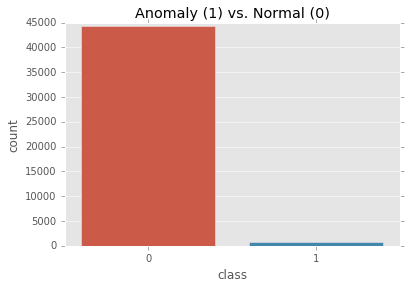

In [18]:
# Getting the data from the csv files
X_train, X_test, y_train, y_test = prepare()

# Cost Function

In [9]:
def find_cost(y_test,predictions):
    normal_false = 0
    anomaly_false = 0
    normal_correct = 0
    anomaly_correct = 0
    for i in range(0, len(predictions)):
        if predictions[i] == 0 and y_test[i] == 1:  # He predicted normal but it was anomaly
            normal_false += 1
        elif predictions[i] == 1 and y_test[i] == 0:  # He predicted anomaly but it was normal
            anomaly_false += 1
        elif predictions[i] == 0 and y_test[i] == 0: # He predicted normal and it was normal
            normal_correct += 1
        elif predictions[i] == 1 and y_test[i] == 1: # He predicted anomaly and it was anomaly
            anomaly_correct += 1
            
    total_cost = 10*anomaly_false + 500*normal_false
    
    # print (("False anomaly predictions are {}".format(anomaly_false)))
    # print (("False normal predictions are {}".format(normal_false)))
    # print (("Correct normal predictions are {}".format(normal_correct)))
    # print (("Correct anomaly predictions are {}".format(anomaly_correct)))
    # print (("Total Cost is {}".format(total_cost)))
    
    return total_cost

    

# Feature Selection

In [10]:
def feature_selection(X_train,y_train, num_of_features, X_test, y_test):
# Build RF classifier to use in feature selection
    knn = KNeighborsClassifier(n_neighbors=3)
    #create new scoring parameter based on cost function
    #cost_scorer = make_scorer(find_cost, greater_is_better= False)
    # Build step forward feature selection
    sfs1 = sfs(knn,
               k_features= num_of_features,
               forward=True,
               floating=False,
               verbose=2,
               scoring="f1",
               cv=5,
               n_jobs=-1)

    # Perform SFFS
    sfs1 = sfs1.fit(X_train, y_train)

    feat_cols = list(sfs1.k_feature_idx_)
    print(feat_cols)
    
    return feat_cols

In [11]:
def execute_classifier(use_training, clf, X_train, X_test, y_train, y_test):

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    # predictions = np.round(predictions)

    
    
    if  use_training:
        prediction_prob = clf.predict_proba(X_test)
       
        predictions = []
        true_labels = []
        for pr in prediction_prob:
            if pr[0] > 0.95:
                predictions.append(0)  # Neg
            else:
                predictions.append(1)  # Pos

    accuracy = 0
    for i in range(0, len(predictions)):
        if predictions[i] == y_test[i]:
            accuracy +=1


    conf_mat = confusion_matrix(y_test, predictions)        
    average_precision = average_precision_score(y_test, predictions)

    #find average precision recall
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, predictions)

    #plot precision recall


    find_cost( y_test, predictions)
    print (("Total Cost is {}".format(total_cost)))

    return predictions, accuracy/len(predictions)

In [ ]:
def print_metrics(prediction, training_x, training_y):
    print("Accuracy Score : ",accuracy_score(prediction,y_test))
    print("F1 Score : ",f1_score(y_test, prediction, average=None))
    print("Presicion Score :",precision_score(y_test, prediction, average=None))
    print("ROC AUC Score :",roc_auc_score(y_test, prediction))
    print("Cross Validation Score :",cross_val_score(model, training_x, training_y, cv=10, n_jobs=-1))  



# KNN with all features

In [12]:
knn = KNeighborsClassifier(3)

predictions, accuracy = execute_classifier(True, knn, X_train, X_test, y_train, y_test)
print("Accuracy of KNN with 170 features, is {} %".format(round((accuracy)*100, 5)))
print_metrics()

Average precision-recall score: 0.32
False anomaly predictions are 220
False normal predictions are 75
Correct normal predictions are 14530
Correct anomaly predictions are 175
Total Cost is 39700
Accuracy of KNN with 170 features, is 98.03333 %


In [19]:
#feat_cols = [9, 14, 21, 33, 37, 57, 94, 161, 162, 165]
feat_cols = [0, 20, 71, 78, 89, 90, 100, 106, 142, 147]
#for name, classifier in classifiers.items():
#for i in feat_cols :
#feat_cols = feature_selection(X_train,y_train, 10, X_test, y_test)
x_train_less_feat = X_train[:, feat_cols]
x_test_less_feat = X_test.iloc[:,feat_cols]

x_train_less_feat.shape



(44917, 10)

In [20]:
x_test_less_feat.shape


(15000, 10)

In [15]:
# predictions after feature reduction
predictions_tocompare, accuracy_tocompare = execute_classifier(True, knn, x_train_less_feat, x_test_less_feat, y_train, y_test)
print("Accuracy of KNN with {} features, is {} %".format(len(feat_cols), round((accuracy_tocompare)*100, 5)))

Average precision-recall score: 0.40
False anomaly predictions are 187
False normal predictions are 56
Correct normal predictions are 14563
Correct anomaly predictions are 194
Total Cost is 29870
Accuracy of KNN with 10 features, is 98.38 %


In [21]:
n_neighbors = [3,5,11,19]
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan"]

hyperF = dict(n_neighbors = n_neighbors, weights = weights,metric = metric)

gridF = GridSearchCV(knn, hyperF, scoring="f1", cv=5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train_less_feat, y_train)

gridF.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   59.9s finished


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [24]:
best_grid = gridF.best_estimator_
#predictions = best_grid.predict(x_test_less_feat)
    # predictions = np.round(predictions)

prediction_prob = best_grid.predict_proba(x_test_less_feat)
       
predictions = []
true_labels = []
for pr in prediction_prob:
    if pr[0] > 0.95:
        predictions.append(0)  # Neg
    else:
        predictions.append(1)  # Pos

accuracy = 0
for i in range(0, len(predictions)):
    if predictions[i] == y_test[i]:
        accuracy +=1


conf_mat = confusion_matrix(y_test, predictions)        
average_precision = average_precision_score(y_test, predictions)

#find average precision recall
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
precision, recall, _ = precision_recall_curve(y_test, predictions)

    #plot precision recall

precision, recall, _ = precision_recall_curve(y_test, predictions)



# write_predictions_to_file(name + '_output.csv.dat', y_test)
find_cost(y_test, predictions)
# print ("Accuracy of {} is {} %".format(name, round((accuracy)*100, 5)))

print("Accuracy of KNN after GridSearch is {} %".format(round((accuracy/len(predictions))*100, 5)))


Average precision-recall score: 0.38
False anomaly predictions are 238
False normal predictions are 45
Correct normal predictions are 14512
Correct anomaly predictions are 205
Total Cost is 24880
Accuracy of KNN after GridSearch is 98.11333 %
